In [2]:
# Imports
import scipy.io as sio
from scipy import stats
from sklearn import linear_model
import numpy as np

# import required libraries
import matplotlib.pyplot as plt
import sys
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops
import scipy
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, Dropout, RepeatVector, LSTM, concatenate, Embedding, Input, BatchNormalization
from keras import backend as K
from keras import regularizers
from keras import callbacks
from sklearn import linear_model
import utils

sys.path.append("../") # go to parent dir
from mrcode.utils.file_utils import fileFinder, folderFinder

## Load data

In [52]:
def std_windows(eeg, time_window = 50):
    temp_eeg = []
    for ii in range(eeg.shape[0]):
        temp_epoch = eeg[ii,:,:]
        temp_eeg.append(np.std(temp_epoch.reshape(int(temp_epoch.shape[0]/time_window),time_window,temp_epoch.shape[1]),1).flatten())
    std_eeg = np.array(temp_eeg)
    return std_eeg

def std_overlap_windows(eeg, time_window = 80, overlap = 0.5):
    temp_eeg = []
    for ii in range(eeg.shape[0]):
        temp_epoch = eeg[ii,:,:]
        std_channels = []
        for jj in range(temp_epoch.shape[1]):
            channel = temp_epoch[:,jj]

            std_channel = []
            for kk in range(int(time_window*overlap)):
                std_channel.append(channel[kk:(kk+time_window)])

            std_channels.append(np.std(std_channel,1))

        temp_eeg.append(std_channels)
        
    temp_eeg_array = np.array(temp_eeg)
    std_temp_eeg = temp_eeg_array.reshape(temp_eeg_array.shape[0],temp_eeg_array.shape[2]*temp_eeg_array.shape[1])
    return std_temp_eeg

def load_data(ii,data_path,feature = 'raw'):
    data = sio.loadmat(data_path + '/' + ii + '/eeg_events.mat')
    eeg = data['eeg_events'].transpose()
    
    if feature == 'raw':
        eeg = eeg.reshape(eeg.shape[0],eeg.shape[2]*eeg.shape[1])
        # normalizing data
        eeg = np.arcsinh(eeg*1000)
    
    if feature == 'std':
        eeg = std_windows(eeg)
        
    if feature == 'std_overlap':
        eeg = std_overlap_windows(eeg)
    
    data_image = sio.loadmat(data_path + '/' + ii + '/image_semantics.mat')
    image_semantics = data_image['image_semantics'].transpose()
    image_info = pd.read_csv(data_path + '/' + ii + '/image_order.txt', delimiter='\t')
    return eeg, image_semantics, image_info

In [53]:
data_path = '../data/experiment_data'
experiment_folders = folderFinder(data_path)
X_temp = []
Y_temp = []
imageids = []
target = 'category'
loadmode = 'raw'
for count_sources, ii in enumerate(experiment_folders):
    
    # first time
    if count_sources == 0:
        eeg, image_semantics, image_info = load_data(ii,data_path, feature = loadmode)
        X_temp = eeg
        Y_temp = image_semantics
        imageids = list(image_info[target].as_matrix())
        
    # after first load
    elif count_sources > 0:
        eeg, image_semantics, image_info = load_data(ii,data_path, feature = loadmode)
        X_temp = np.vstack((X_temp,eeg))
        Y_temp = np.vstack((Y_temp,image_semantics))
        imageids = np.hstack((imageids,list(image_info[target].as_matrix())))

## Ridge regression CV StandardScaler Normalization

In [32]:
# Normalize data
#xScale = MinMaxScaler(feature_range=(0,1)).fit(X_temp) # MinMaxScaler(feature_range = (-1,1)) 
xScale = StandardScaler().fit(X_temp) 
X_temp = xScale.transform(X_temp)
# Median scalering 

In [33]:
# Loop over all test set n = 30

alpha = 10000
MSE_all = [] # 30
MSE_norm_all = []
E_delta_all = [] # 
E_delta_lower_zero_all = [] # 30

for i in range(30):
    
    # Data processing
    test_split = range(i,690*len(experiment_folders),30)
    
    # Prepare target data
    Y_test = Y_temp[test_split,:]
    Y_train = np.delete(Y_temp,test_split,0)

    # Prepare input data
    X_test = X_temp[test_split,:]
    X_train = np.delete(X_temp,test_split,0)
    
    # Finding the variance of the test set to use as 
    E_nul_values = np.var(Y_test, 0)
    Y_testt = np.transpose(Y_test)

    print('Cross validation fold : ' +str(i))
    # Making the regression
    clf = Ridge(alpha)
    clf.fit(X_train, Y_train)
    # Fitting the values
    Y_pred = clf.predict(X_test)
    # Saving the overall MSE
    MSE = mean_squared_error(Y_test,Y_pred)
    MSE_all.append(MSE)
    MSE_norm = MSE/np.mean(E_nul_values)
    MSE_norm_all.append(MSE_norm)
    print('MSE: ' + str(MSE))
    print('MSEnorm: ' + str(MSE_norm))
    
    Y_predt = np.transpose(Y_pred)
    # Calculating MSE across the images for each location of the 2048 image semantic locations
    E_values = []
    for j in range(len(Y_predt)):
        e = mean_squared_error(Y_testt[j], Y_predt[j])
        E_values.append(e)
    
    # Calculating the E delta (E/E_0)
    E_delta = np.divide(E_values,E_nul_values)
    E_delta_all.append(E_delta)

    # Checking how many values are smaller than 1
    lower = sum(E_delta < 1)
    E_delta_lower_zero_all.append(lower)
    print('Number of E-deltas lower than zero: ' + str(lower))

Cross validation fold : 0
MSE: 0.11292300176276827
MSEnorm: 1.278764194995996
Number of E-deltas lower than zero: 0
Cross validation fold : 1
MSE: 0.09545183751330098
MSEnorm: 1.0682295023109158
Number of E-deltas lower than zero: 40
Cross validation fold : 2
MSE: 0.0927901124303051
MSEnorm: 1.0589397431232788
Number of E-deltas lower than zero: 57
Cross validation fold : 3
MSE: 0.09031563572652207
MSEnorm: 1.030264869566299
Number of E-deltas lower than zero: 190
Cross validation fold : 4
MSE: 0.09109379932073004
MSEnorm: 1.0299779571858292
Number of E-deltas lower than zero: 190
Cross validation fold : 5
MSE: 0.09249992380187484
MSEnorm: 1.0281604205733261
Number of E-deltas lower than zero: 239
Cross validation fold : 6
MSE: 0.09220925887616618
MSEnorm: 1.0228322007372537
Number of E-deltas lower than zero: 259
Cross validation fold : 7
MSE: 0.09022906640626416
MSEnorm: 1.0302310547329876
Number of E-deltas lower than zero: 201
Cross validation fold : 8
MSE: 0.09367048424771054
MSEn

In [35]:
np.mean(MSE_all)

0.09289466685347209

In [36]:
np.mean(MSE_norm_all)

1.0449242578451174

In [37]:
np.mean(E_delta_lower_zero_all)

154.3

In [44]:
E_delta_lower_zero_all_standard = E_delta_lower_zero_all

In [46]:
E_delta_lower_zero_all_standard

[0,
 40,
 57,
 190,
 190,
 239,
 259,
 201,
 205,
 41,
 192,
 142,
 187,
 170,
 108,
 194,
 116,
 129,
 135,
 247,
 249,
 150,
 158,
 197,
 149,
 117,
 132,
 229,
 61,
 145]

In [45]:
file = open('standard_scaler_experiment.txt','w')

for i in range(30):
    file.write(str(i) + ' & ' + str(round(MSE_all[i],3)) + ' & ' +  str(round(MSE_norm_all[i],3)) + ' & ' + str(E_delta_lower_zero_all[i])+ '\\\\ \n')

file.close()

## Brugt ingenting til at normalisere data

In [48]:
# Loop over all test set n = 30

alpha = 10000
MSE_all = [] # 30
E_delta_all = [] # 
E_delta_lower_zero_all = [] # 30

for i in range(30):
    
    # Data processing
    test_split = range(i,690*len(experiment_folders),30)
    
    # Prepare target data
    Y_test = Y_temp[test_split,:]
    Y_train = np.delete(Y_temp,test_split,0)

    # Prepare input data
    X_test = X_temp[test_split,:]
    X_train = np.delete(X_temp,test_split,0)
    
    # Finding the variance of the test set to use as 
    E_nul_values = np.var(Y_test, 0)
    Y_testt = np.transpose(Y_test)

    print('Cross validation fold : ' +str(i))
    # Making the regression
    clf = Ridge(alpha)
    clf.fit(X_train, Y_train)
    # Fitting the values
    Y_pred = clf.predict(X_test)
    # Saving the overall MSE
    MSE = mean_squared_error(Y_test,Y_pred)
    MSE_all.append(MSE)
    MSE_norm = MSE/np.mean(E_nul_values)
    MSE_norm_all.append(MSE_norm)
    print('MSE: ' + str(MSE))
    print('MSEnorm: ' + str(MSE_norm))
    
    Y_predt = np.transpose(Y_pred)
    # Calculating MSE across the images for each location of the 2048 image semantic locations
    E_values = []
    for j in range(len(Y_predt)):
        e = mean_squared_error(Y_testt[j], Y_predt[j])
        E_values.append(e)
    
    # Calculating the E delta (E/E_0)
    E_delta = np.divide(E_values,E_nul_values)
    E_delta_all.append(E_delta)

    # Checking how many values are smaller than 1
    lower = sum(E_delta < 1)
    E_delta_lower_zero_all.append(lower)
    print('Number of E-deltas lower than zero: ' + str(lower))

Cross validation fold : 0
MSE: 0.21410001423799463
MSEnorm: 2.4245142980776597
Number of E-deltas lower than zero: 0
Cross validation fold : 1
MSE: 0.13161531317272931
MSEnorm: 1.4729455623880299
Number of E-deltas lower than zero: 0
Cross validation fold : 2
MSE: 0.12874439771239848
MSEnorm: 1.4692574011539021
Number of E-deltas lower than zero: 0
Cross validation fold : 3
MSE: 0.11704484305545487
MSEnorm: 1.3351751221579957
Number of E-deltas lower than zero: 0
Cross validation fold : 4
MSE: 0.1178104162220073
MSEnorm: 1.3320569867585021
Number of E-deltas lower than zero: 0
Cross validation fold : 5
MSE: 0.11902693425150093
MSEnorm: 1.3230149577387693
Number of E-deltas lower than zero: 0
Cross validation fold : 6
MSE: 0.11732103389511139
MSEnorm: 1.3013848365581395
Number of E-deltas lower than zero: 0
Cross validation fold : 7
MSE: 0.11749194371854725
MSEnorm: 1.3415172507136155
Number of E-deltas lower than zero: 0
Cross validation fold : 8
MSE: 0.12079117673538639
MSEnorm: 1.331

In [49]:
clf.get_params()

{'alpha': 10000,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [50]:
print(np.mean(MSE_all))
print(np.mean(MSE_norm_all))
print(np.mean(E_delta_lower_zero_all))

0.12340812575556344
1.2166469153729136
0.0


In [51]:
file = open('nonorm_experiment.txt','w')

for i in range(30):
    file.write(str(i) + ' & ' + str(round(MSE_all[i],3)) + ' & ' +  str(round(MSE_norm_all[i],3)) + ' & ' + str(E_delta_lower_zero_all[i])+ '\\\\ \n')

file.close()

## Brugt asinh til at normalisere data

In [54]:
# Loop over all test set n = 30

alpha = 0.1
MSE_all = [] # 30
E_delta_all = [] # 
E_delta_lower_zero_all = [] # 30

for i in range(30):
    
    # Data processing
    test_split = range(i,690*len(experiment_folders),30)
    
    # Prepare target data
    Y_test = Y_temp[test_split,:]
    Y_train = np.delete(Y_temp,test_split,0)

    # Prepare input data
    X_test = X_temp[test_split,:]
    X_train = np.delete(X_temp,test_split,0)
    
    # Finding the variance of the test set to use as 
    E_nul_values = np.var(Y_test, 0)
    Y_testt = np.transpose(Y_test)

    print('Cross validation fold : ' +str(i))
    # Making the regression
    clf = Ridge(alpha)
    clf.fit(X_train, Y_train)
    # Fitting the values
    Y_pred = clf.predict(X_test)
    # Saving the overall MSE
    MSE = mean_squared_error(Y_test,Y_pred)
    MSE_all.append(MSE)
    MSE_norm = MSE/np.mean(E_nul_values)
    MSE_norm_all.append(MSE_norm)
    print('MSE: ' + str(MSE))
    print('MSEnorm: ' + str(MSE_norm))
    
    Y_predt = np.transpose(Y_pred)
    # Calculating MSE across the images for each location of the 2048 image semantic locations
    E_values = []
    for j in range(len(Y_predt)):
        e = mean_squared_error(Y_testt[j], Y_predt[j])
        E_values.append(e)
    
    # Calculating the E delta (E/E_0)
    E_delta = np.divide(E_values,E_nul_values)
    E_delta_all.append(E_delta)

    # Checking how many values are smaller than 1
    lower = sum(E_delta < 1)
    E_delta_lower_zero_all.append(lower)
    print('Number of E-deltas lower than zero: ' + str(lower))

Cross validation fold : 0
MSE: 0.3164341740039088
MSEnorm: 3.583368184273209
Number of E-deltas lower than zero: 0
Cross validation fold : 1
MSE: 0.32850638864600723
MSEnorm: 3.6764113210537275
Number of E-deltas lower than zero: 0
Cross validation fold : 2
MSE: 0.3192861924154296
MSEnorm: 3.643759337323319
Number of E-deltas lower than zero: 0
Cross validation fold : 3
MSE: 0.31901582820764846
MSEnorm: 3.6391351064965196
Number of E-deltas lower than zero: 0
Cross validation fold : 4
MSE: 0.3318106419563661
MSEnorm: 3.7517114196922448
Number of E-deltas lower than zero: 0
Cross validation fold : 5
MSE: 0.3186681267154837
MSEnorm: 3.5420781090466678
Number of E-deltas lower than zero: 0
Cross validation fold : 6
MSE: 0.32441233811634435
MSEnorm: 3.598547367000101
Number of E-deltas lower than zero: 0
Cross validation fold : 7
MSE: 0.3202789032419149
MSEnorm: 3.6569288083948837
Number of E-deltas lower than zero: 0
Cross validation fold : 8
MSE: 0.32283882799003893
MSEnorm: 3.5589389622

In [55]:
print(np.mean(MSE_all))
print(np.mean(MSE_norm_all))
print(np.mean(E_delta_lower_zero_all))

0.32442872932123124
2.0276783032003283
0.0


In [56]:
file = open('asinh_experiment.txt','w')

for i in range(30):
    file.write(str(i) + ' & ' + str(round(MSE_all[i],3)) + ' & ' +  str(round(MSE_norm_all[i],3)) + ' & ' + str(E_delta_lower_zero_all[i])+ '\\\\ \n')

file.close()

## Ridge Regression in loop to optimize alpha

In [3]:
X_train = np.load('../data/pred_image_semantics/X_trainVal.npy')
Y_train = np.load('../data/pred_image_semantics/Y_trainVal.npy')
imageids_train = np.load('../data/pred_image_semantics/imageids_trainVal.npy')
X_test = np.load('../data/pred_image_semantics/X_test.npy')
Y_test = np.load('../data/pred_image_semantics/Y_test.npy')
imageids_test = np.load('../data/pred_image_semantics/imageids_test.npy')
X_val = np.load('../data/pred_image_semantics/X_val.npy')
Y_val = np.load('../data/pred_image_semantics/Y_val.npy')
imageids_val = np.load('../data/pred_image_semantics/imageids_val.npy')

In [4]:
# Finding the variance of the test set to use as 
E_nul_values = np.var(Y_val, 0)
Y_testt = np.transpose(Y_val)

In [5]:
# List of all alpha values we want to test
alpha = [0.001,0.01,0.1,1,10,100,1000,10000,100000]
E_delta_lower_zero = []
MSEs = []
E_delta_list = []
MSE_norm_all = []

for i in alpha:
    print('Running ridge regression with alpha: ' +str(i))
    # Making the regression
    clf = Ridge(alpha=i)
    clf.fit(X_train, Y_train)
    # Fitting the values
    Y_pred = clf.predict(X_val)
    
    # Changing negative values to 0
    Y_pred_nonneg = []
    for pred in Y_pred:
        new_imsem = []
        for j in pred:
            if j < 0:
                new_imsem.append(0)
            else:
                new_imsem.append(j)
        Y_pred_nonneg.append(new_imsem)

    Y_pred_nonneg = np.asarray(Y_pred_nonneg)
    
    # Saving the overall MSE
    MSE = mean_squared_error(Y_val,Y_pred_nonneg)
    MSEs.append(MSE)
    print('MSE: ' + str(MSE))
    MSE_norm = MSE/np.mean(E_nul_values)
    MSE_norm_all.append(MSE_norm)
    print('MSE: ' + str(MSE))
    print('MSEnorm: ' + str(MSE_norm))
    
    Y_predt = np.transpose(Y_pred_nonneg)
    # Calculating MSE across the images for each location of the 2048 image semantic locations
    E_values = []
    for j in range(len(Y_predt)):
        e = mean_squared_error(Y_testt[j], Y_predt[j])
        E_values.append(e)
    
    # Calculating the E delta (E/E_0)
    E_delta = np.divide(E_values,E_nul_values)
    E_delta_list.append(E_delta)
    # Checking how many values are smaller than 1
    lower = sum(E_delta < 1)
    E_delta_lower_zero.append(lower)
    print('Number of E-deltas lower than zero: ' + str(lower))

Running ridge regression with alpha: 0.001
MSE: 0.13271864879334033
MSE: 0.13271864879334033
MSEnorm: 1.4702880524804518
Number of E-deltas lower than zero: 0
Running ridge regression with alpha: 0.01
MSE: 0.13195929277527016
MSE: 0.13195929277527016
MSEnorm: 1.4618757299387555
Number of E-deltas lower than zero: 0
Running ridge regression with alpha: 0.1
MSE: 0.1311414966161109
MSE: 0.1311414966161109
MSEnorm: 1.4528159939249528
Number of E-deltas lower than zero: 0
Running ridge regression with alpha: 1
MSE: 0.129999570866685
MSE: 0.129999570866685
MSEnorm: 1.4401654749401263
Number of E-deltas lower than zero: 0
Running ridge regression with alpha: 10
MSE: 0.12649241743450537
MSE: 0.12649241743450537
MSEnorm: 1.4013124136979274
Number of E-deltas lower than zero: 0
Running ridge regression with alpha: 100
MSE: 0.1160052217714057
MSE: 0.1160052217714057
MSEnorm: 1.2851328215481468
Number of E-deltas lower than zero: 0
Running ridge regression with alpha: 1000
MSE: 0.10248352572349985

In [18]:
round(MSEs[0],2)

0.13

In [22]:
len(MSEs)

9

In [27]:
file = open('alpha_experiment.txt','w')

for i in range(9):
    file.write(str(alpha[i]) + ' & ' + str(round(MSEs[i],2)) + ' & ' +  str(round(MSE_norm_all[i],2)) + ' & ' + str(E_delta_lower_zero[i])+ '\\\\ \n')

file.close()

In [7]:
# Data processing
test_split = range(20,690*len(experiment_folders),30)

# Prepare target data
Y_test = Y_temp[test_split,:]
Y_train = np.delete(Y_temp,test_split,0)

# Prepare input data
X_test = X_temp[test_split,:]
X_train = np.delete(X_temp,test_split,0)

In [8]:
# Finding the variance of the test set to use as 
E_nul_values = np.var(Y_test, 0)
Y_testt = np.transpose(Y_test)

In [9]:
# List of all alpha values we want to test
alpha = [0.001,0.01,0.1,1,10,100,1000,10000]
E_delta_lower_zero = []
MSEs = []
E_delta_list = []

for i in alpha:
    print('Running ridge regression with alpha: ' +str(i))
    # Making the regression
    clf = Ridge(alpha=i)
    clf.fit(X_train, Y_train)
    # Fitting the values
    Y_pred = clf.predict(X_test)
    # Saving the overall MSE
    MSE = mean_squared_error(Y_test,Y_pred)
    MSEs.append(MSE)
    print('MSE: ' + str(MSE))
    
    Y_predt = np.transpose(Y_pred)
    # Calculating MSE across the images for each location of the 2048 image semantic locations
    E_values = []
    for i in range(len(Y_predt)):
        e = mean_squared_error(Y_testt, Y_predt)
        E_values.append(e)
    
    # Calculating the E delta (E/E_0)
    E_delta = np.divide(E_values,E_nul_values)
    E_delta_list.append(E_delta)
    # Checking how many values are smaller than 1
    lower = sum(E_delta < 1)
    E_delta_lower_zero.append(lower)
    print('Number of E-deltas lower than zero: ' + str(lower))

Running ridge regression with alpha: 0.001
MSE: 0.12899646634524622
Number of E-deltas lower than zero: 293
Running ridge regression with alpha: 0.01
MSE: 0.12804035721859808
Number of E-deltas lower than zero: 298
Running ridge regression with alpha: 0.1
MSE: 0.12705866700321145
Number of E-deltas lower than zero: 308
Running ridge regression with alpha: 1
MSE: 0.1258251972005299
Number of E-deltas lower than zero: 317
Running ridge regression with alpha: 10
MSE: 0.12200387040915103
Number of E-deltas lower than zero: 352
Running ridge regression with alpha: 100
MSE: 0.11126206394960328
Number of E-deltas lower than zero: 480
Running ridge regression with alpha: 1000
MSE: 0.09899323503065033
Number of E-deltas lower than zero: 663
Running ridge regression with alpha: 10000
MSE: 0.09275624090190125
Number of E-deltas lower than zero: 784


In [16]:
E_delta_lower_zero

[293, 298, 308, 317, 352, 480, 663, 784]

In [17]:
MSEs

[0.12899646634524622,
 0.12804035721859808,
 0.12705866700321145,
 0.1258251972005299,
 0.12200387040915103,
 0.11126206394960328,
 0.09899323503065033,
 0.09275624090190125]

In [16]:
for i in E_delta_list[7]:
    if i < 1:
        print(i)

0.9677345866478279
0.7799810073231291
0.5918764077405825
0.9563187787414448
0.8751899153855567
0.571044658915909
0.9956183079477526
0.7314913343323036
0.7840151075425064
0.6779852109622871
0.4902860602483744
0.945768643808227
0.8549727573924519
0.692352246012505
0.5967161791163849
0.8084832966054152
0.4860447939980331
0.6725673976591537
0.9933530541946615
0.890030929321156
0.6143576139720073
0.8040234401132016
0.6256732226455112
0.9835806884228563
0.986378348527738
0.43418713351829097
0.6178205148377214
0.8726499275374624
0.9991293132749198
0.8687052895935422
0.9316253276375479
0.9491115228662034
0.7750803428482863
0.9623807017923727
0.8809687193165534
0.842442788315323
0.9979043150663374
0.8697613621599521
0.6146247642207726
0.6776534429286496
0.9330749439252483
0.8125260270469644
0.8180395416200236
0.7370464055751137
0.9940874653931855
0.9640077773708637
0.9487487181255205
0.8203080264836922
0.9472965924935114
0.8712618425504073
0.7021014269422101
0.7972404780083902
0.761393437341377

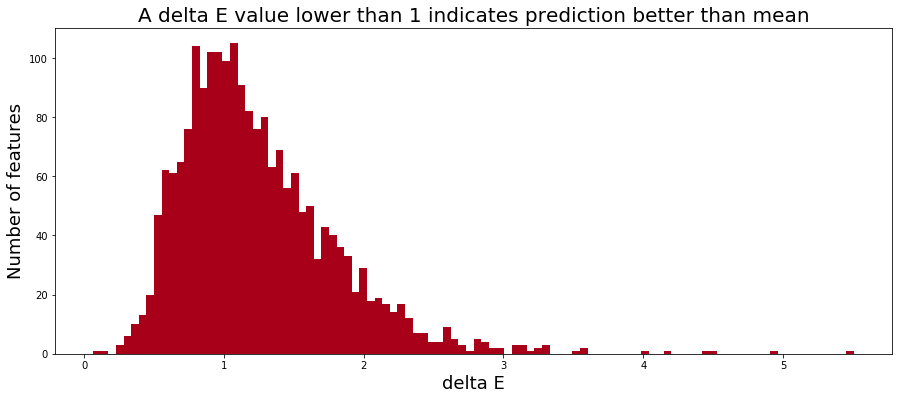

In [26]:
plt.figure(figsize=(15,6))
plt.hist(E_delta_list[7], bins = 100, color = '#a80018')
plt.title('A delta E value lower than 1 indicates prediction better than mean', fontsize = 20)
plt.xlabel('delta E', fontsize = 18)
plt.ylabel('Number of features', fontsize = 18)
plt.show()

#### Test på test set

In [64]:
# Data processing
test_split = range(4,690*len(experiment_folders),30)
    
# Prepare target data
Y_test = Y_temp[test_split,:]
Y_train = np.delete(Y_temp,test_split,0)
Y_train = np.delete(Y_train,val_split,0)

# Prepare input data
X_test = X_temp_scale[test_split,:]
X_train = np.delete(X_temp_scale,test_split,0)
X_train = np.delete(X_train,val_split,0)

In [12]:
# Tester på test set
clf = Ridge(alpha=1000)
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)

In [13]:
mean_squared_error(Y_test,Y_pred)

0.09899323503065033

In [14]:
Y_predt = np.transpose(Y_pred)
Y_testt = np.transpose(Y_test)
E_nul_values = np.var(Y_test, 0)

# Calculating MSE across the images for each location of the 2048 image semantic locations
E_values = []
for i in range(len(Y_predt)):
    e = mean_squared_error(Y_testt, Y_predt)
    E_values.append(e)

E_delta = np.divide(E_values,E_nul_values)

sum(E_delta < 1)

663

In [92]:
E_delta[100]

1.9416090988471304

In [93]:
E_nul_values[100]

0.0636146

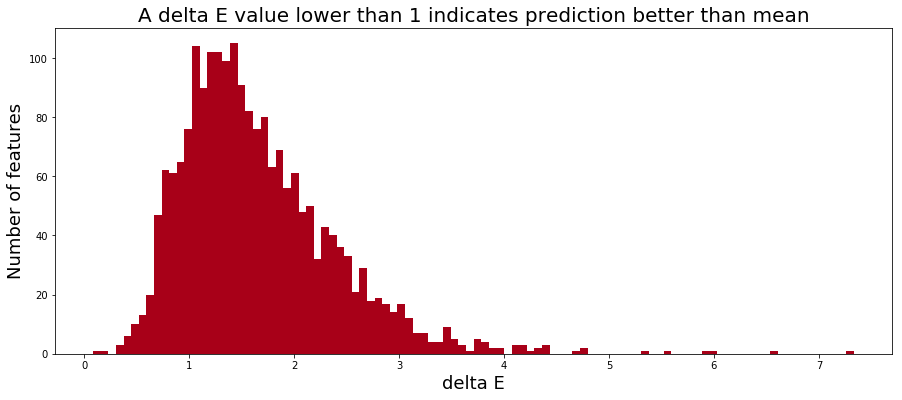

In [94]:
plt.figure(figsize=(15,6))
plt.hist(E_delta, bins = 100, color = '#a80018')
plt.title('A delta E value lower than 1 indicates prediction better than mean', fontsize = 20)
plt.xlabel('delta E', fontsize = 18)
plt.ylabel('Number of features', fontsize = 18)
plt.show()

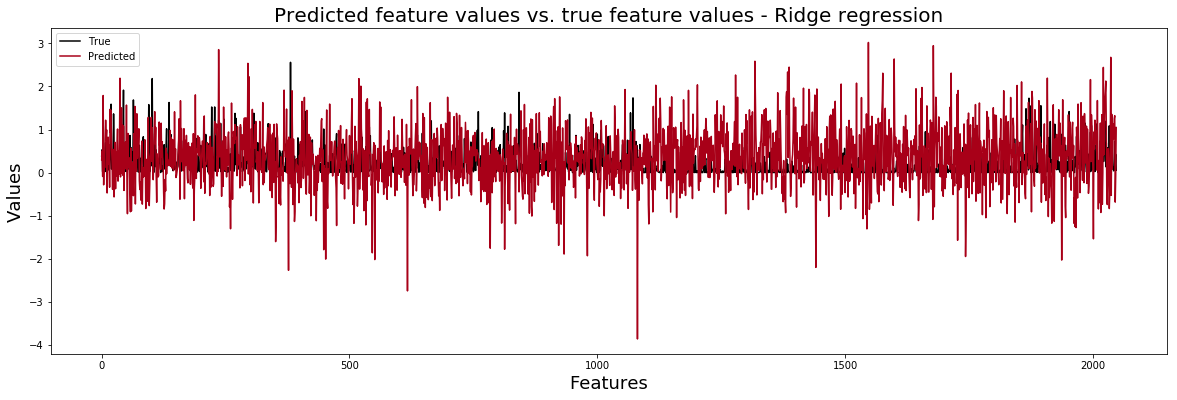

In [32]:
# Plotting true and pred against each other
plt.figure(figsize=(20,6))
image = 20
plt.plot(range(2048), Y_test[image], color = 'black')
plt.plot(range(2048), Y_pred[image], color = '#a80018')
plt.title('Predicted feature values vs. true feature values - Ridge regression', fontsize = 20)
plt.xlabel('Features', fontsize = 18)
plt.ylabel('Values', fontsize = 18)
plt.legend(['True', 'Predicted'])
plt.show()

## Saving true and predicted to matlab

In [73]:
#Getting pred and true to matlab for making representational similarity plot 
sio.savemat('image_semantics_ridge_pred.mat', {'image_semantics_Y_pred':Y_pred})
sio.savemat('image_semantics_ridge_true.mat', {'image_semantics_Y_test':Y_test})

## Neural Network Prediction

In [33]:
# Printing shape of data
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(9660, 17600)
(9660, 2048)
(345, 17600)
(345, 2048)


In [34]:
model = None

In [50]:
# Resetting model (to be able to work in Jupyter)
session = K.get_session()
if model is not None:
    model.reset_states()
    
# Defining variables
num_features = X_train.shape[1]
num_classes = Y_train.shape[1]
num_neurons_l1 = 1000
num_neurons_l2 = 1000
num_layers = 2
batch_size = 64
num_epochs = 5

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

# Defining the model
model = Sequential()

# Adding dense layers
print('Creating layer', 1)
model.add(Dense(units = num_neurons_l1, input_dim = num_features, activation = 'relu', kernel_regularizer = regularizers.l2(0.01), name = 'layer1'))

model.add(BatchNormalization())

# Adding dense layers
print('Creating layer', 2)
model.add(Dense(units = num_neurons_l2, activation = 'relu', kernel_regularizer = regularizers.l2(0.01), name = 'layer2'))
#kernel_regularizer = regularizers.l2(0.005),

model.add(BatchNormalization())
# then we add a new Dense layer with the size of the image semantics vectors
print('Creating output layer')
model.add(Dense(units = num_classes, name='output_layer'))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=[rmse])

Creating layer 1
Creating layer 2
Creating output layer


In [51]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 1000)              17601000  
_________________________________________________________________
batch_normalization_7 (Batch (None, 1000)              4000      
_________________________________________________________________
layer2 (Dense)               (None, 1000)              1001000   
_________________________________________________________________
batch_normalization_8 (Batch (None, 1000)              4000      
_________________________________________________________________
output_layer (Dense)         (None, 2048)              2050048   
Total params: 20,660,048
Trainable params: 20,656,048
Non-trainable params: 4,000
_________________________________________________________________
None


In [52]:
train_history = model.fit(X_train, Y_train,
          validation_data = (X_val, Y_val),
          epochs=num_epochs, 
          batch_size=batch_size)

Train on 9660 samples, validate on 345 samples
Epoch 1/5
9660/9660 [==============================] - 54s 6ms/step - loss: 2.2127 - rmse: 0.3803 - val_loss: 0.2698 - val_rmse: 0.3631
Epoch 2/5
9660/9660 [==============================] - 52s 5ms/step - loss: 0.1788 - rmse: 0.3186 - val_loss: 0.1556 - val_rmse: 0.3175
Epoch 3/5
9660/9660 [==============================] - 52s 5ms/step - loss: 0.1470 - rmse: 0.3151 - val_loss: 0.1451 - val_rmse: 0.3198
Epoch 4/5
9660/9660 [==============================] - 52s 5ms/step - loss: 0.1431 - rmse: 0.3138 - val_loss: 0.1990 - val_rmse: 0.3658
Epoch 5/5
9660/9660 [==============================] - 52s 5ms/step - loss: 0.1446 - rmse: 0.3143 - val_loss: 0.1521 - val_rmse: 0.3297


In [ ]:
loss, accuracy = model.evaluate(X_test, 
                                utils.onehot(targets_test, num_classes), 
                                batch_size=128)

In [53]:
Y_pred_NN = model.predict(X_val, batch_size=batch_size)

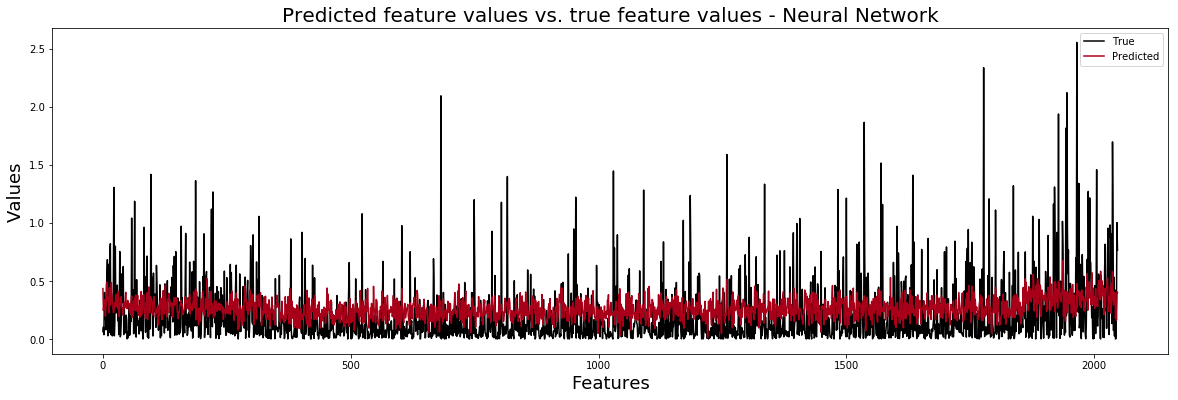

In [54]:
# Plotting true and pred against each other
plt.figure(figsize=(20,6))
plt.plot(range(2048), Y_val[300], color = 'black')
plt.plot(range(2048), Y_pred_NN[300], color = '#a80018')
plt.title('Predicted feature values vs. true feature values - Neural Network', fontsize = 20)
plt.xlabel('Features', fontsize = 18)
plt.ylabel('Values', fontsize = 18)
plt.legend(['True', 'Predicted'])
plt.show()

In [55]:
Y_predt_NN = np.transpose(Y_pred_NN)
Y_testt = np.transpose(Y_val)
E_nul_values = np.var(Y_val, 0)

# Calculating MSE across the images for each location of the 2048 image semantic locations
E_values = []
for i in range(len(Y_predt_NN)):
    e = mean_squared_error(Y_testt, Y_predt_NN)
    E_values.append(e)

E_delta = np.divide(E_values,E_nul_values)
E_nul_values
sum(E_delta < 1)

402

In [46]:
E_delta[100]

1.334585

In [49]:
E_values[100]

0.08966014

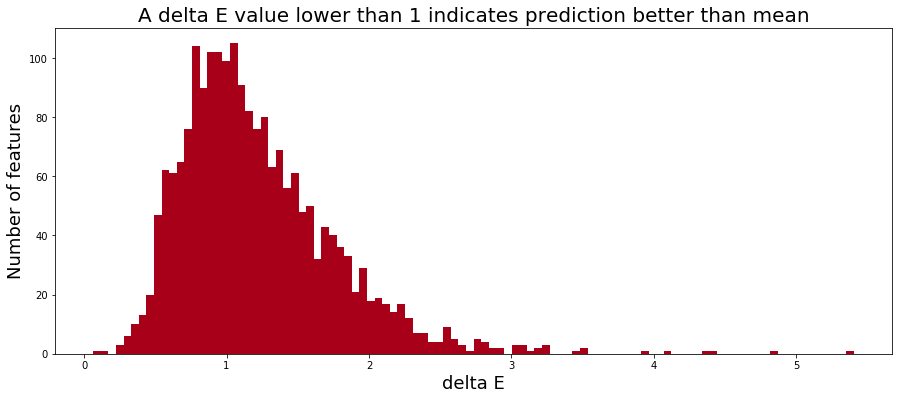

In [108]:
plt.figure(figsize=(15,6))
plt.hist(E_delta, bins = 100, color = '#a80018')
plt.title('A delta E value lower than 1 indicates prediction better than mean', fontsize = 20)
plt.xlabel('delta E', fontsize = 18)
plt.ylabel('Number of features', fontsize = 18)
plt.show()

In [67]:
mean_test =np.mean(Y_test,1)
mean_pred = np.mean(Y_pred,1)

In [68]:
mean_test.shape

(345,)

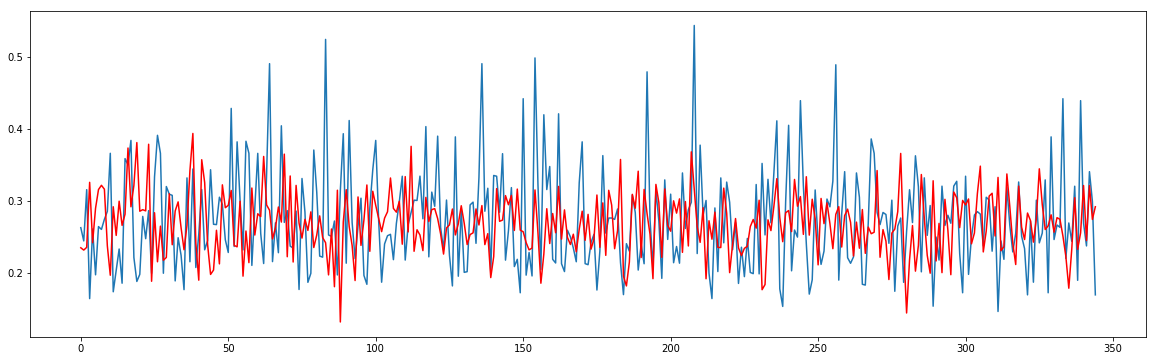

In [69]:
# Plotting true and pred against each other
plt.figure(figsize=(20,6))
plt.plot(range(345), mean_test)
plt.plot(range(345), mean_pred, color = 'red')
plt.show()